In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import mplcyberpunk
import tensorflow as tf

2024-09-19 14:52:04.608021: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 14:52:04.611103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 14:52:04.620112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 14:52:04.635671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 14:52:04.640459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 14:52:04.652679: I tensorflow/core/platform/cpu_feature_gu

In [25]:
tickers = ['PETR4.SA']
petr4 = yf.download(tickers, start = '2013-01-02', end = '2021-12-30')

petr4

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.990000,20.209999,19.690001,19.690001,5.817048,30182600
2013-01-03,19.809999,20.400000,19.700001,20.400000,6.026805,30552600
2013-01-04,20.330000,20.620001,20.170000,20.430000,6.035668,36141000
2013-01-07,20.480000,20.670000,19.950001,20.080000,5.932266,28069600
2013-01-08,20.110001,20.230000,19.459999,19.500000,5.760916,29091300
...,...,...,...,...,...,...
2021-12-22,28.400000,28.400000,27.969999,28.160000,11.986901,33734500
2021-12-23,28.330000,28.420000,28.150000,28.330000,12.059264,28713600
2021-12-27,28.320000,28.780001,28.150000,28.750000,12.238048,44227900


In [26]:
petr4 = petr4.reset_index()

petr4['Date'] = pd.to_datetime(petr4['Date'], format = '%Y-%m-%d')

In [30]:
precos = petr4['Close']

# O RNN observa toda a série temporal, entretanto ele é particularmente
# sensível a um intervalo próoximo, o qual iremos definir na próxima linha
sensibilidade = 15

# Definindo o quanto da nossa base de dados será utilizada para treinamento
treino_size = int(len(precos) * 0.95)

# Definindo o quanto da nossa base de dados será utilizada para teste
teste_size = len(precos) - treino_size

# Definindo os dados de treinamento e, ao que eu entendi até o momento, os
# dados com maior sensibilidade, armazenados em teste_data
treino_data, teste_data = np.array(precos[:treino_size]), np.array(precos[treino_size - sensibilidade:])

# Dados de validação, ao que eu entendi serão usados para comparar com os
# valores encontrandos pela rede neural
val_data = np.array(precos[treino_size:])

treino_data.shape[0], teste_data.shape[0]

(2121, 127)

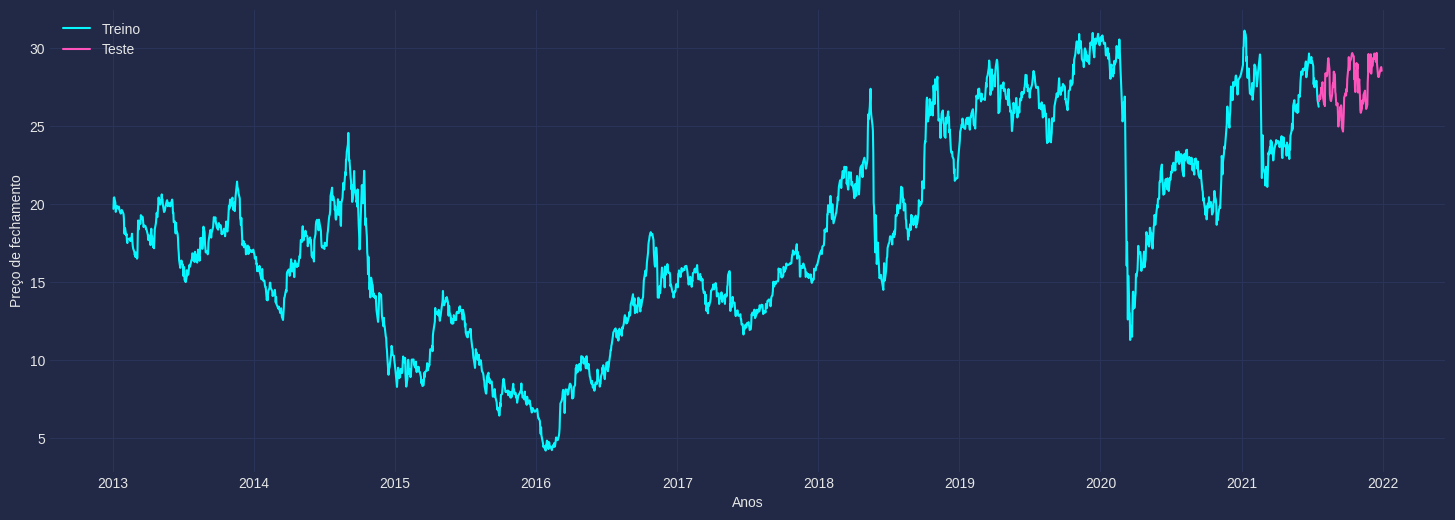

In [54]:
plt.rcParams['figure.figsize'] = [18, 6]
plt.style.use('cyberpunk')

plt.plot(petr4['Date'][:treino_size], petr4['Close'][:treino_size], label = 'Treino')
plt.plot(petr4['Date'][treino_size:], petr4['Close'][treino_size:], label = 'Teste')
plt.xlabel('Anos')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
scaler = MinMaxScaler(feature_range = (0, 1))

treino_data_normalizado = scaler.fit_transform(np.array(treino_data).reshape(-1, 1))
teste_data_normalizado = scaler.transform(np.array(teste_data).reshape(-1, 1))
val_data_normalizado = scaler.transform(np.array(val_data).reshape(-1, 1))

treino_data_normalizado.shape

#Notas: observe que há uma sutileza no processo de normalização dos dados, de
# forma que, enquanto utilizamos o fit_transform para os dados de treinamento,
#usamos apenas transform para os demais. Segundo o tutorial, se aplicarmos
# o fit_transform ao teste, estamos ajudando o algoritmo, tornando os
# resultados inviesados pra aquilo que já deveria ser, como se estivéssimos
# dando cola pra ele. Não ficou tão claro pra mim a forma como isso acontece,
#se eu descobrir(e lembrar), eu volto aqui com a explicação.

(2121, 1)